In [1]:
import os
from PIL import Image
import pandas as pd
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import numpy as np


In [2]:
# Define the paths to your dataset directories
data_root = r'D:\RAFDB\RAF-DB\RAF-DB-20231017T081935Z-001\RAF-DB\basic'
image_dir = os.path.join(data_root, 'Image\\aligned\\aligned')
annotation_dir = os.path.join(data_root, 'Annotation/manual')
emotion_labels_path = os.path.join(data_root, 'EmoLabel/list_patition_label.txt')


In [3]:

# Define data transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize to 100x100
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Load emotion labels into a DataFrame
emotion_labels = pd.read_csv(emotion_labels_path, sep=' ', names=['image_name', 'emotion_label'], header=None)


In [4]:
# Rename the image names in the DataFrame
emotion_labels['image_name'] = emotion_labels['image_name'].str.replace('.jpg', '_aligned.jpg')


In [5]:
emotion_labels['image_name']

0        train_00001_aligned.jpg
1        train_00002_aligned.jpg
2        train_00003_aligned.jpg
3        train_00004_aligned.jpg
4        train_00005_aligned.jpg
                  ...           
15334      test_3064_aligned.jpg
15335      test_3065_aligned.jpg
15336      test_3066_aligned.jpg
15337      test_3067_aligned.jpg
15338      test_3068_aligned.jpg
Name: image_name, Length: 15339, dtype: object

In [6]:
# # Create empty lists for image tensors and emotion labels
# x_train = []
# y_train = []

# # Loop through the dataset to load images and labels
# for idx in range(len(emotion_labels)):
#     image_name = emotion_labels.iloc[idx, 0]
#     image_path = os.path.join(image_dir, image_name)
#     image = Image.open(image_path)
#     if transform:
#         image = transform(image)
    
#     # Load emotion label
#     emotion_label = emotion_labels.iloc[idx, 1]

#     x_train.append(image)
#     y_train.append(emotion_label)

# # Convert the lists to PyTorch tensors
# x_train = torch.stack(x_train)
# y_train = torch.tensor(y_train)

# # Now, x_train contains the image data, and y_train contains the corresponding emotion labels.


In [7]:
# To load the tensor back
x = np.load('x_raf.npy')
y = np.load('y_raf.npy')

In [8]:
# convert X and y to Tensors
x = torch.Tensor(x) # features
y = torch.as_tensor(y)

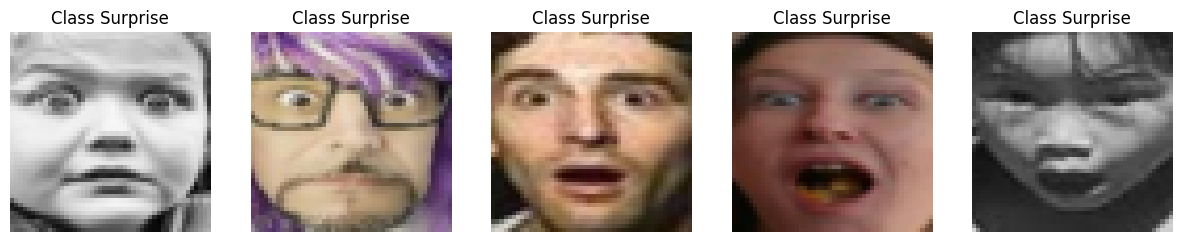

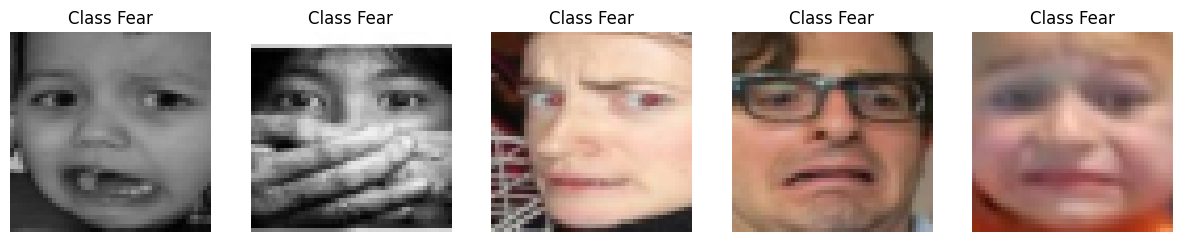

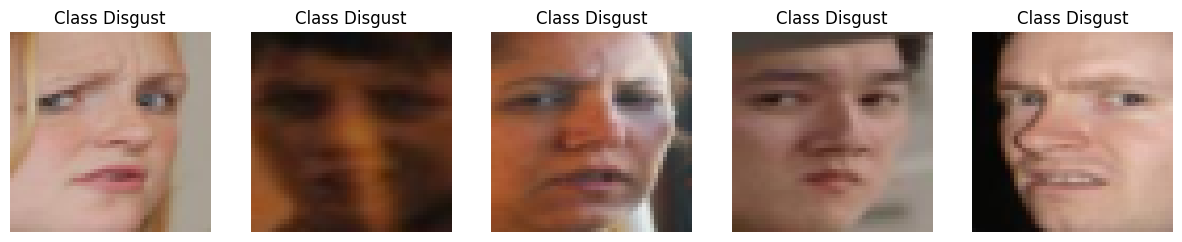

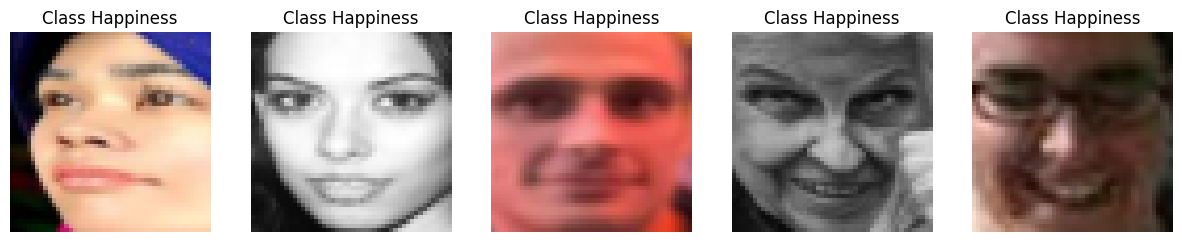

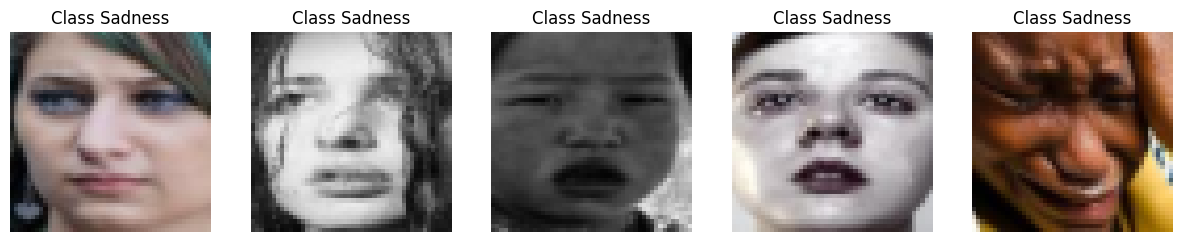

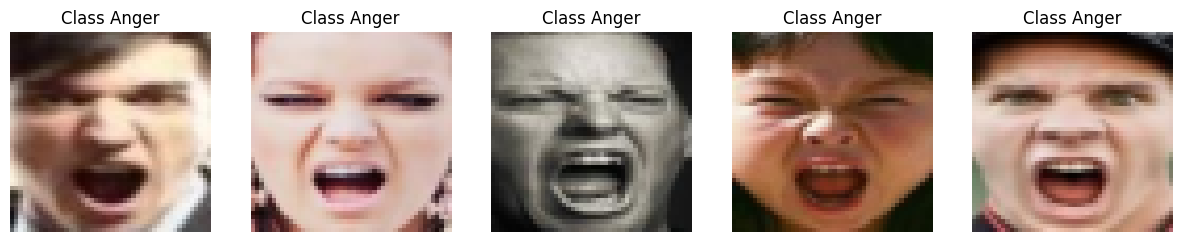

In [9]:
import matplotlib.pyplot as plt

# Assuming you have your x_train and y_train tensors ready
# Each class is represented by a number, e.g., 1 for "Surprise," 2 for "Fear," and so on.

# Create a list of class labels corresponding to the emotions
class_labels = ["Fear", "Disgust", "Happiness", "Sadness", "Anger","Surprise", ]

# Function to plot images from a specific class
def plot_images_from_class(class_id, num_images=5):
    class_indices = (y == class_id).nonzero().squeeze()  # Find indices of images from the specified class
    num_samples = min(num_images, class_indices.shape[0])

    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x[class_indices[i]].permute(1, 2, 0), cmap='gray')  # Assuming images are grayscale
        plt.title(f"Class {class_labels[class_id - 1]}")
        plt.axis('off')
    plt.show()

# Plot images from each class
for class_id in range(0, len(class_labels)):
    plot_images_from_class(class_id, num_images=5)


In [10]:
# Define a filter condition to exclude the "Neutral" class (class_id = 7)
filter_condition = (y != 6)  # Class ID 7 corresponds to "Neutral"

# Apply the filter condition to x_train and y_train
x = x[filter_condition]
y = y[filter_condition]


saving the np arr

In [11]:
# np.save('x_raf.npy', x)
# np.save('y_raf.npy', y)

In [12]:
x.shape

torch.Size([12135, 3, 48, 48])

In [13]:
from torchvision.models import resnet18  # Import ResNet-18
from torch.nn import Linear
import torch.optim as optim  # Import the optimizer module

# Create a ResNet-18 model
model = resnet18(pretrained=True)  # Load pretrained ResNet-18

# Modify the classifier (fully connected) layer
n_features = model.fc.in_features
model.fc = Linear(n_features, 6)  # Assuming you have 7 classes

# Define the optimizer (e.g., SGD)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


d:\anaconda\envs\TORCHGPU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\TORCHGPU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Using avalanche to train

In [14]:
# add data transformations: (1) convert to tensor format, and (2) normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=180),
])

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_trial, y_train, y_trial = train_test_split(x, y, test_size=0.20, random_state=42)

In [16]:
from avalanche.benchmarks.utils import make_tensor_classification_dataset
trainds = make_tensor_classification_dataset(X_train, y_train)
testds = make_tensor_classification_dataset(X_trial, y_trial)

d:\anaconda\envs\TORCHGPU\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
d:\anaconda\envs\TORCHGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
trainds

_FlatDataWithTransform (len=9708,subset=False,cat=False,cf=True)
	_TensorClassificationDataset (len=9708)

In [18]:
from avalanche.benchmarks import nc_scenario
from avalanche.training.plugins import EvaluationPlugin
from avalanche.benchmarks.utils import make_tensor_classification_dataset
from avalanche.training.supervised import Naive, Replay
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics, disk_usage_metrics, cpu_usage_metrics, timing_metrics
from torch.optim import SGD

In [19]:
# split the dataset into tasks
nb_tasks = 3

cl_scenario = nc_scenario(
    train_dataset=trainds,
    test_dataset=testds,
    n_experiences=3,
    task_labels=True,
    seed=1234
)

In [25]:
import gc
torch.cuda.empty_cache()
gc.collect()

2795

In [26]:
import torch
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'



cuda:0


In [27]:
# chossing the Naive strategy
cl_strategy = Naive(
    model,
    optimizer,
    torch.nn.CrossEntropyLoss(),
    train_mb_size=300,
    train_epochs=2,
    eval_mb_size=80,
    device=device
)

In [28]:
# Preparing a training plugin
evaluation = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    cpu_usage_metrics(experience=True),
    timing_metrics(),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
)

# here we add a plugin to the strategy
cl_strategy.evaluator = evaluation


In [29]:
results = []
for experience in cl_scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(cl_scenario.test_stream, num_workers=4))


Start of experience:  0
Current Classes:  [2, 3]
-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 19/19 [00:24<00:00,  1.31s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8198
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7679
100%|██████████| 19/19 [00:20<00:00,  1.08s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3490
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8692
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 17/17 [00:12<00:00,  1.33it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.3839
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8631
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 9/9 [00:12<00:00,  1.38s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task001/Exp001 = 10.0384
	Top1_Acc_Exp/eval